In [6]:
import argparse
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
import random
import torch.nn.functional as F
from model_utility import *
from dataset_utility import *
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from cka_utility import *
# from seaborn import heatmap

from config import Config
from models import *

import numpy as np
from plot import *
parser = argparse.ArgumentParser(description='FQ-ViT')

parser.add_argument('--model',
                    choices=[
                        'deit_tiny', 'deit_small', 'deit_base', 'vit_base',
                        'vit_large', 'swin_tiny', 'swin_small', 'swin_base'
                    ],
                    default='deit_tiny',
                    help='model')
parser.add_argument('--data', metavar='DIR',
                    default='/data/deepops/temp/easy-lora-and-gptq/imagenet',
                    help='path to dataset')
parser.add_argument('--quant', default=True, action='store_true')
parser.add_argument('--ptf', default=True)
parser.add_argument('--lis', default=True)
parser.add_argument('--quant-method',
                    default='minmax',
                    choices=['minmax', 'ema', 'omse', 'percentile'])
parser.add_argument('--mixed', default=True, action='store_true')
# TODO: 100 --> 32
parser.add_argument('--calib-batchsize',
                    default=100,
                    type=int,
                    help='batchsize of calibration set')
parser.add_argument("--mode", default=0,
                        type=int, 
                        help="mode of calibration data, 0: PSAQ-ViT, 1: Gaussian noise, 2: Real data")
# TODO: 10 --> 1
parser.add_argument('--calib-iter', default=10, type=int)
# TODO: 100 --> 200
parser.add_argument('--val-batchsize',
                    default=200,
                    type=int,
                    help='batchsize of validation set')
parser.add_argument('--num-workers',
                    default=16,
                    type=int,
                    help='number of data loading workers (default: 16)')
parser.add_argument('--device', default='cuda', type=str, help='device')
parser.add_argument('--print-freq',
                    default=100,
                    type=int,
                    help='print frequency')
parser.add_argument('--seed', default=0, type=int, help='seed')



args = parser.parse_args(args=[])
seed(args.seed)

device = torch.device(args.device)
cfg = Config(args.ptf, args.lis, args.quant_method)
# model = str2model(args.model)(pretrained=True, cfg=cfg)
# model = model.to(device)



# Note: Different models have different strategies of data preprocessing.
model_type = args.model.split('_')[0]
if model_type == 'deit':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.875
elif model_type == 'vit':
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    crop_pct = 0.9
elif model_type == 'swin':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.9
else:
    raise NotImplementedError
train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)
val_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

# Data
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

val_dataset = datasets.ImageFolder(valdir, val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.val_batchsize,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
)
# switch to evaluate mode
# model.eval()

# define loss function (criterion)
criterion = nn.CrossEntropyLoss().to(device)

train_dataset = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)




In [7]:
int8_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
int4_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
not_quantized_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)

eight_bit_config = [8]*50
#basic_net, epsilon, step_size, num_steps, bit_config, args
not_quantized_attack_net = AttackPGD(
    basic_net=not_quantized_model, 
    epsilon=0.06,
    step_size=0.01,
    num_steps=50,
    bit_config=None,
    args=args)
four_bit_config = [4]*50
seed_images, seed_labels = not_quantized_attack_net.get_seed_inputs(50, rand=False)
adv_inputs = not_quantized_attack_net.gen_adv_inputs(seed_images, seed_labels)

int8_model = calibrate_model(args.mode, args, int8_model, train_loader, device)
int4_model = calibrate_model(args.mode, args, int4_model, train_loader, device)


int8_model.eval()
int4_model.eval()
not_quantized_model.eval()

print()



Model: deit_tiny_patch16_224


/mnt/data/anaconda3/envs/forch/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224
Calibrating with real data...
Calibrating with real data...



In [3]:
compute_cka_with_adversarial(not_quantized_model,
                             int4_model, 
                             use_batch = True, 
                             normalize_act = False, 
                             cka_batch = 50, #원래는 cifar10 256장.
                             cka_iter = 15, 
                             result_name='cka_with_adversarial_not_quantized_int4_model_test', 
                             model1_bit_config = None,
                             model2_bit_config = four_bit_config,
                             args = args)

현재 반복: 0
현재 반복: 1
현재 반복: 2
현재 반복: 3
현재 반복: 4
현재 반복: 5
현재 반복: 6
현재 반복: 7
현재 반복: 8
현재 반복: 9
현재 반복: 10
현재 반복: 11
현재 반복: 12
현재 반복: 13
현재 반복: 14


In [4]:
compute_cka_with_adversarial(not_quantized_model,
                             int8_model, 
                             use_batch = True, 
                             normalize_act = False, 
                             cka_batch = 50, #원래는 cifar10 256장.
                             cka_iter = 15, 
                             result_name='cka_with_adversarial_not_quantized_int8_model_test', 
                             model1_bit_config = None,
                             model2_bit_config = eight_bit_config,
                             args = args)

현재 반복: 0
현재 반복: 1
현재 반복: 2
현재 반복: 3
현재 반복: 4


In [4]:

plot_cka_map(
    cka_file_name= 'cka_with_adversarial_not_quantized_int4_model_test', 
    plot_name = 'cka_with_adversarial_not_quantized_int4_model_test',
    base_dir= '/data/deepops/temp/diff-ViT'
    )


# 사용 예시
pickle_folder = 'cka_with_adversarial_not_quantized_int4_model_test'
#qkv, proj, mlp_fc1, mlp_fc2

comprehensive_pickle_file = f'{pickle_folder}/cka_with_adversarial_not_quantized_int4_model_test_heatmap'

qkv_pickle_file = f'{pickle_folder}/cka_qkv'
proj_pickle_file = f'{pickle_folder}/cka_proj'
mlp_fc1_pickle_file = f'{pickle_folder}/cka_mlp_fc1'
mlp_fc2_pickle_file = f'{pickle_folder}/cka_mlp_fc2'





comprehensive_diagonal = load_and_plot_diagonal(comprehensive_pickle_file)
qkv_diagonal = load_and_plot_diagonal(qkv_pickle_file)
proj_diagonal = load_and_plot_diagonal(proj_pickle_file)
mlp_fc1_diagonal = load_and_plot_diagonal(mlp_fc1_pickle_file)
mlp_fc2_diagonal = load_and_plot_diagonal(mlp_fc2_pickle_file)


# 대각 값들 출력
print("comprehensive_Diagonal values:", comprehensive_diagonal)
print("qkv_Diagonal values:", qkv_diagonal)
print("proj_Diagonal values:", proj_diagonal)
print("mlp_fc1_Diagonal values:", mlp_fc1_diagonal)
print("mlp_fc2_Diagonal values:", mlp_fc2_diagonal)



pickle_files = [
    f'{pickle_folder}/cka_with_adversarial_not_quantized_int4_model_test_heatmap',
    f'{pickle_folder}/cka_qkv',
    f'{pickle_folder}/cka_proj',
    f'{pickle_folder}/cka_mlp_fc1',
    f'{pickle_folder}/cka_mlp_fc2'
]

labels = ['Comprehensive', 'QKV', 'Proj', 'MLP FC1', 'MLP FC2']

plot_all_diagonals(pickle_files, labels)

# 대각 값들 출력
for pickle_file, label in zip(pickle_files, labels):
    diagonal = load_diagonal(pickle_file)
    print(f"{label} Diagonal values:", diagonal)

NameError: name 'plot_cka_map' is not defined

음수 기울기 중 절댓값이 가장 큰 5개의 기울기 쌍:
Layers 46-47: -0.425846
Layers 44-45: -0.231227
Layers 42-43: -0.203097
Layers 40-41: -0.172983
Layers 38-39: -0.166989
Layers 24-25: -0.157125


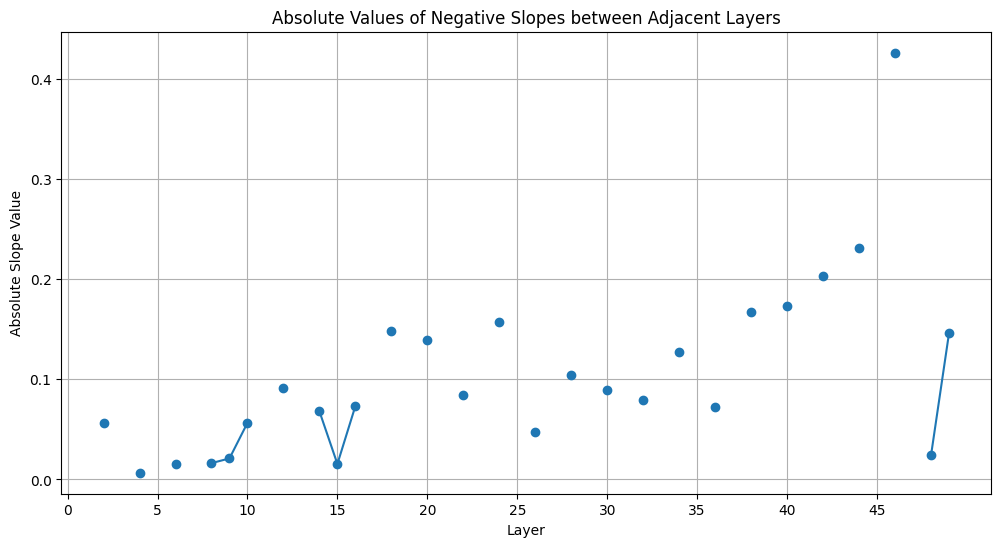

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 데이터
diagonal_values = [0.9844448, 0.9932241, 0.93696433, 0.9890642, 0.98236245, 0.98273927, 0.9669165, 0.97682315, 0.96053445, 0.93956995, 0.883112, 0.9153894, 0.82392144, 0.94314486, 0.87513494, 0.8596895, 0.78642637, 0.9355694, 0.78753734, 0.8946206, 0.75526136, 0.8556227, 0.7713002, 0.8730264, 0.7159015, 0.8325918, 0.7855737, 0.85561025, 0.7514658, 0.834453, 0.7451548, 0.79941905, 0.7197552, 0.82510316, 0.6981765, 0.76884013, 0.6962489, 0.783298, 0.6163095, 0.80576235, 0.63277966, 0.76214015, 0.5590432, 0.7734749, 0.5422483, 0.7486398, 0.32279363, 0.61376655, 0.58972996, 0.44388658]

# 기울기 계산
slopes = np.diff(diagonal_values)

# 음수 기울기만 선택
negative_slopes = slopes[slopes < 0]
negative_slopes_indices = np.where(slopes < 0)[0]

# 음수 기울기 중 절댓값이 가장 큰 5개의 기울기 쌍 찾기
abs_negative_slopes = np.abs(negative_slopes)
top_5_indices = np.argsort(abs_negative_slopes)[-6:][::-1]
top_5_pairs = [(negative_slopes_indices[i], negative_slopes_indices[i]+1, negative_slopes[i]) for i in top_5_indices]

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), np.where(slopes < 0, np.abs(slopes), np.nan), marker='o')
plt.title('Absolute Values of Negative Slopes between Adjacent Layers')
plt.xlabel('Layer')
plt.ylabel('Absolute Slope Value')
plt.xticks(range(0, 50, 5))
plt.grid(True)

# 결과 출력
print("음수 기울기 중 절댓값이 가장 큰 5개의 기울기 쌍:")
for pair in top_5_pairs:
    print(f"Layers {pair[0]+1}-{pair[1]+1}: {pair[2]:.6f}")

plt.show()

(50, 50) (12, 12)
(50, 50) (12, 12)
(50, 50) (12, 12)
(50, 50) (12, 12)
x | y : 1 1
x | y : 1 1
x | y : 1 1
x | y : 1 1
x | y : 1 1
comprehensive_Diagonal values: [0.99995625 0.9998222  0.9618598  0.99114233 0.98927575 0.98081774
 0.97399014 0.9916075  0.9838714  0.9833205  0.95527107 0.97384286
 0.94652236 0.9815717  0.96525097 0.8840243  0.9316232  0.9758672
 0.9463648  0.9656021  0.9301359  0.9594402  0.9461311  0.96651655
 0.91986203 0.9602192  0.94617265 0.96751755 0.9301654  0.96058965
 0.9466139  0.95920706 0.93962485 0.9606636  0.94326705 0.9495371
 0.9359741  0.9542013  0.9204234  0.9575103  0.9129619  0.9433468
 0.9068178  0.9535174  0.8602062  0.9428642  0.8243578  0.91840893
 0.90653473 0.8802853 ]
qkv_Diagonal values: [0.9998222  0.98081774 0.9833205  0.9815717  0.9758672  0.9594402
 0.9602192  0.96058965 0.9606636  0.9542013  0.9433468  0.9428642 ]
proj_Diagonal values: [0.9618598  0.97399014 0.95527107 0.96525097 0.9463648  0.9461311
 0.94617265 0.9466139  0.94326705 0.9

FileNotFoundError: [Errno 2] No such file or directory: 'cka_with_adversarial_not_quantized_int8_model_test/cka_with_adversarial_not_quantized_int8_model_test_test_heatmap.pkl'

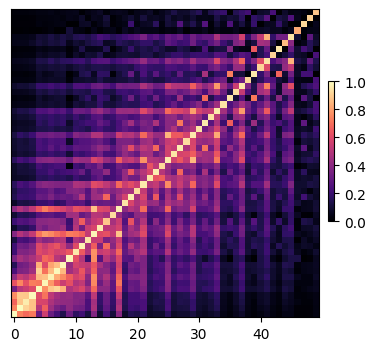

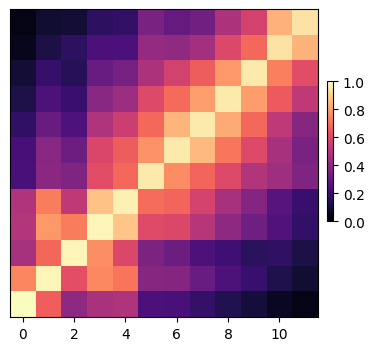

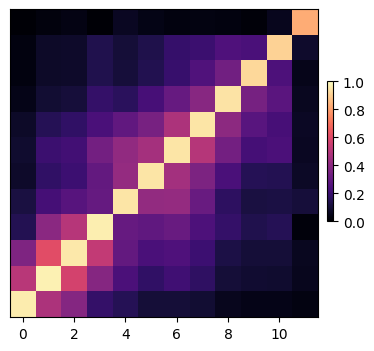

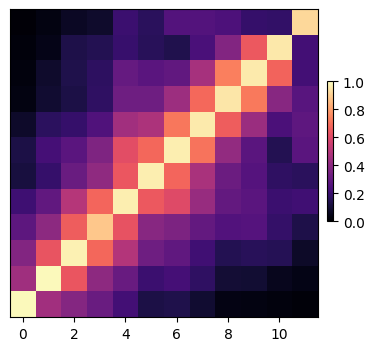

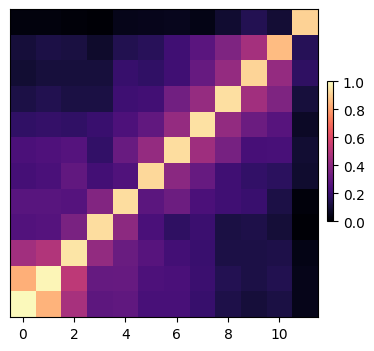

<Figure size 1500x800 with 0 Axes>

In [14]:

plot_cka_map(
    cka_file_name= 'cka_with_adversarial_not_quantized_int8_model_test', 
    plot_name = 'cka_with_adversarial_not_quantized_int8_model_test',
    base_dir= '/data/deepops/temp/diff-ViT'
    )


# 사용 예시
pickle_folder = 'cka_with_adversarial_not_quantized_int8_model_test'
#qkv, proj, mlp_fc1, mlp_fc2

comprehensive_pickle_file = f'{pickle_folder}/cka_with_adversarial_not_quantized_int8_model_test_heatmap'

qkv_pickle_file = f'{pickle_folder}/cka_qkv'
proj_pickle_file = f'{pickle_folder}/cka_proj'
mlp_fc1_pickle_file = f'{pickle_folder}/cka_mlp_fc1'
mlp_fc2_pickle_file = f'{pickle_folder}/cka_mlp_fc2'





comprehensive_diagonal = load_and_plot_diagonal(comprehensive_pickle_file)
qkv_diagonal = load_and_plot_diagonal(qkv_pickle_file)
proj_diagonal = load_and_plot_diagonal(proj_pickle_file)
mlp_fc1_diagonal = load_and_plot_diagonal(mlp_fc1_pickle_file)
mlp_fc2_diagonal = load_and_plot_diagonal(mlp_fc2_pickle_file)


# 대각 값들 출력
print("comprehensive_Diagonal values:", comprehensive_diagonal)
print("qkv_Diagonal values:", qkv_diagonal)
print("proj_Diagonal values:", proj_diagonal)
print("mlp_fc1_Diagonal values:", mlp_fc1_diagonal)
print("mlp_fc2_Diagonal values:", mlp_fc2_diagonal)



pickle_files = [
    f'{pickle_folder}/cka_with_adversarial_not_quantized_int8_model_test_heatmap',
    f'{pickle_folder}/cka_qkv',
    f'{pickle_folder}/cka_proj',
    f'{pickle_folder}/cka_mlp_fc1',
    f'{pickle_folder}/cka_mlp_fc2'
]

labels = ['Comprehensive', 'QKV', 'Proj', 'MLP FC1', 'MLP FC2']

plot_all_diagonals(pickle_files, labels)

# 대각 값들 출력
for pickle_file, label in zip(pickle_files, labels):
    diagonal = load_diagonal(pickle_file)
    print(f"{label} Diagonal values:", diagonal)